In [1]:
## convolve ecco forcing with adjoint sensitivity to recover time series and test wind stress convention

In [68]:
import xarray as xr
import numpy as np
from scipy.ndimage import convolve1d
import sys
sys.path.append('/glade/u/home/noahrose/ECCOv4-py/')
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

In [2]:
import xmitgcm 

In [4]:
vname = 'tauu'#'tauv'

pathname = '/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T700_full_mask_v2.bin_1'

    
fname = f'{pathname}/output/adxx_{vname}.0000000129.data'
adjfile = np.fromfile(fname,dtype='>f4')

nx = 90
ny = 1170
nt = adjfile.shape[0]//nx//ny
adj_sensitivity =  ecco.llc_compact_to_tiles(adjfile.reshape(nt,ny,nx))



llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [13]:
ecco_forcing = xr.open_mfdataset('/glade/work/noahrose/ECCOV4r4/nctiles_monthly/oceTAUE/*/*.nc',engine='netcdf4')
ecco_forcing.load()

<xarray.Dataset> Size: 132MB
Dimensions:    (time: 312, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * j          (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i          (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    timestep   (time) int64 2kB 732 1428 2172 2892 ... 226452 227172 227904
  * time       (time) datetime64[ns] 2kB 1992-01-16T12:00:00 ... 2017-12-16
    XC         (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    time_bnds  (time, nv) datetime64[ns] 5kB 1992-01-01 ... 2017-12-31T12:00:00
Dimensions without coordinates: nv
Data variables:
    oceTAUE    (time, tile, j, i) float32 131MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/26)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nx:                           90
    ny:                           90
    geospatial_lon_max:           179.98691
    geospatial_lon_min:           -179.98895
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

In [31]:
import pandas as pd
ecco_interp= ecco_forcing.interp(time=pd.date_range("1/1/1992", "12/31/2017", periods=1352))

In [41]:
ecco_interp

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 1352, tile: 13, j: 90, i: 90)
Coordinates:
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    timestep  (time) float64 11kB nan nan nan 861.6 ... 2.278e+05 nan nan nan
    XC        (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC        (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * time      (time) datetime64[ns] 11kB 1992-01-01 ... 2017-12-31
Data variables:
    oceTAUE   (time, tile, j, i) float64 1GB nan nan nan nan ... nan nan nan nan
Attributes: (12/26)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nx:                           90
    ny:                           90
    geospatial_lon_max:           179.98691
    geospatial_lon_min:           -179.98895
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

In [27]:
adj_sensitivity[4:-2].shape

(1352, 13, 90, 90)

In [51]:
from scipy.signal import oaconvolve
conv = oaconvolve(adj_sensitivity,ecco_interp.oceTAUE,axes=0,mode='valid')

In [52]:
np.nanmax(conv)

/glade/derecho/scratch/noahrose/tmp/ipykernel_57981/2201357432.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(conv)


np.float64(nan)

In [74]:
test_ustress = np.fromfile('/glade/work/darr/EMUfiles/emu_input_dir/forcing/other/flux-forced/forcing_weekly/tauu_weekly_v1.0000001008.data','>f4')

In [75]:
test_ustress.shape
nx = 90
ny = 1170
nt = test_ustress.shape[0]//nx//ny
test_ustress = ecco.llc_compact_to_tiles(test_ustress.reshape(nt,ny,nx))


llc_compact_to_faces: dims, llc  (1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [76]:
test_ustress.shape

(1, 13, 90, 90)

(<Figure size 900x789 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

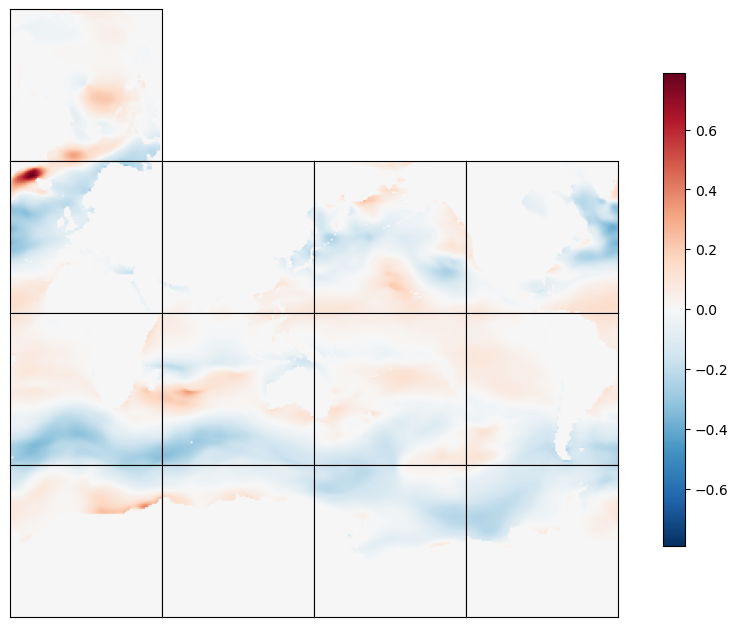

In [77]:
ecco.plot_tiles(test_ustress[0],layout='latlon',rotate_to_latlon='True',show_tile_labels=False,show_colorbar=True,less_output=True)

(<Figure size 900x789 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

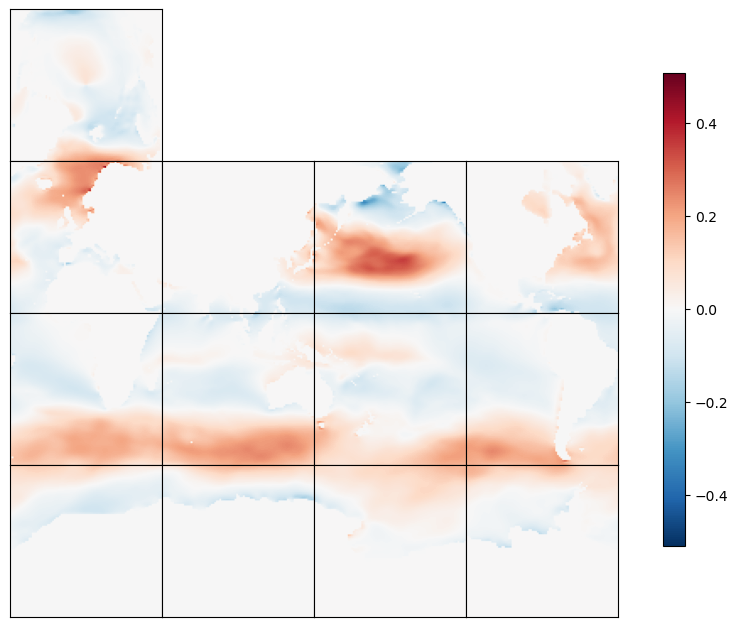

In [78]:
ecco.plot_tiles(ecco_forcing.oceTAUE[0],rotate_to_latlon=True,layout='latlon',show_tile_labels=False,show_colorbar=True)